In [24]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [25]:
#load captions and image names here if you haven't already
captions = np.load("captions.npy")
image_names = np.load("image_names.npy")

In [26]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [27]:
## add start and end to captions
training_captions = []
for c in captions:
    training_captions.append(f"<start> {c} <end>")

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(training_captions)

In [28]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(training_captions)

In [29]:
# tokenize captions
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(training_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [30]:
# split data into training and testing
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_names, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [31]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [32]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap
def pretrain_map_func(img_name, cap, y):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap, y

In [33]:
indices = [i for i in range(len(img_name_train))]
vis_img_name_pretrain = []
vis_cap_pretrain      = []
vis_y_pretrain        = []
for (i, (img_name, cap)) in enumerate(zip(img_name_train, cap_train)):
    randIndex = np.random.choice(indices)
    randIndex = indices[(indices.index(i) + 1) % len(indices)] if randIndex == i else randIndex
    #add false example to pretrain
    vis_img_name_pretrain.append(img_name_train[randIndex])
    vis_cap_pretrain.append(cap_train[randIndex])
    vis_y_pretrain.append(np.array([0]).astype("int32"))

    #add positive example to pretrain
    vis_img_name_pretrain.append(img_name)
    vis_cap_pretrain.append(cap)
    vis_y_pretrain.append(np.array([1]).astype("int32"))
    
    #remove the index
    indices.remove(randIndex)

visPretrainDataset = tf.data.Dataset.from_tensor_slices((vis_img_name_pretrain, vis_cap_pretrain, vis_y_pretrain))

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
visPretrainDataset = visPretrainDataset.map(lambda item1, item2, item3: tf.numpy_function(
          pretrain_map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.int32])
          )

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32])
          )

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(BUFFER_SIZE)
visPretrainDataset = visPretrainDataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
visPretrainDataset = visPretrainDataset.prefetch(BUFFER_SIZE)

In [34]:
# pretrained weights for feature extraction in eval
# use pretrained imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [35]:
# these functions can be used to load an image given the image name. could be useful if you want to see the OG image
import boto3
from PIL import Image
from io import BytesIO
import numpy as np

bucket_name = "caption-images-cs231m"

def read_image_from_s3(filename):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    s3 = boto3.resource('s3')

    bucket = s3.Bucket(bucket_name)
    object = bucket.Object(filename)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)

# load images from the bucket & reshape to correct size
def load_image(image_path):
    img = tf.convert_to_tensor(read_image_from_s3(str(image_path)))
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

In [36]:
# this function loads an image locally
def load_image_local(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Once everything above is run, the dataset (10k images right now) is ready for a model

In [37]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [38]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [39]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
vis_classifier = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

In [41]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [42]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# pre-training

In [44]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [45]:
def visual_loss_function(real, pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(real, pred)

In [46]:
def visual_pretrain_step(img_tensor, caption, y):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=caption.shape[0])

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(caption.shape[1]):
            _, hidden, _ = decoder(caption[:, i:i+1], features, hidden)
                
        prediction = vis_classifier(hidden)
            
        loss = visual_loss_function(y, prediction)

    trainable_variables = encoder.trainable_variables \
              + decoder.trainable_variables + vis_classifier.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [47]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, cap, y)) in enumerate(visPretrainDataset):
        t_loss = visual_pretrain_step(img_tensor, cap, y)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = t_loss
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 12 Batch 0 Loss 0.7077


Epoch 12 Batch 100 Loss 0.7412


Epoch 12 Batch 200 Loss 0.7074


Epoch 12 Loss 1.421733
Time taken for 1 epoch 193.97 sec

Epoch 13 Batch 0 Loss 0.7103


Epoch 13 Batch 100 Loss 0.7018


Epoch 13 Batch 200 Loss 0.7160


Epoch 13 Loss 1.403450
Time taken for 1 epoch 193.72 sec

Epoch 14 Batch 0 Loss 0.6997


Epoch 14 Batch 100 Loss 0.6977


Epoch 14 Batch 200 Loss 0.6970


Epoch 14 Loss 1.399077
Time taken for 1 epoch 195.46 sec

Epoch 15 Batch 0 Loss 0.7086


Epoch 15 Batch 100 Loss 0.6951


Epoch 15 Batch 200 Loss 0.6928


Epoch 15 Loss 1.400240
Time taken for 1 epoch 195.00 sec

Epoch 16 Batch 0 Loss 0.7191


Epoch 16 Batch 100 Loss 0.7004


Epoch 16 Batch 200 Loss 0.6921


Epoch 16 Loss 1.397516
Time taken for 1 epoch 194.57 sec

Epoch 17 Batch 0 Loss 0.6966


Epoch 17 Batch 100 Loss 0.7011


Epoch 17 Batch 200 Loss 0.7106


Epoch 17 Loss 1.398588
Time taken for 1 epoch 192.46 sec

Epoch 18 Batch 0 Loss 0.7037


Epoch 18 Batch 100 Loss 0.7039


Epoch 18 Batch 200 Loss 0.6929


Epoch 18 Loss 1.399512
Time taken for 1 epoch 192.59 sec

Epoch 19 Batch 0 Loss 0.7019


Epoch 19 Batch 100 Loss 0.7031


Epoch 19 Batch 200 Loss 0.7009


Epoch 19 Loss 1.396913
Time taken for 1 epoch 192.44 sec

Epoch 20 Batch 0 Loss 0.7007


Epoch 20 Batch 100 Loss 0.7094


Epoch 20 Batch 200 Loss 0.6950


Epoch 20 Loss 1.396289
Time taken for 1 epoch 191.94 sec



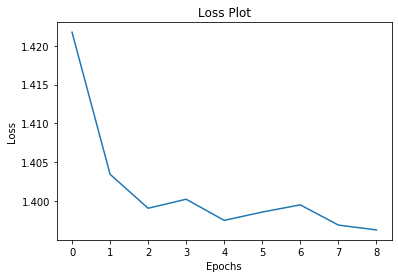

In [48]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [52]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [54]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 12 Batch 0 Loss 0.8339
Epoch 12 Batch 100 Loss 0.8412
Epoch 12 Loss 0.800273
Time taken for 1 epoch 84.45 sec

Epoch 13 Batch 0 Loss 0.5992
Epoch 13 Batch 100 Loss 0.6568
Epoch 13 Loss 0.651828
Time taken for 1 epoch 47.25 sec

Epoch 14 Batch 0 Loss 0.5509
Epoch 14 Batch 100 Loss 0.5534
Epoch 14 Loss 0.541139
Time taken for 1 epoch 47.33 sec

Epoch 15 Batch 0 Loss 0.4587
Epoch 15 Batch 100 Loss 0.5280
Epoch 15 Loss 0.457279
Time taken for 1 epoch 47.39 sec

Epoch 16 Batch 0 Loss 0.3915
Epoch 16 Batch 100 Loss 0.4200
Epoch 16 Loss 0.392358
Time taken for 1 epoch 47.51 sec

Epoch 17 Batch 0 Loss 0.3340
Epoch 17 Batch 100 Loss 0.2890
Epoch 17 Loss 0.336666
Time taken for 1 epoch 47.42 sec

Epoch 18 Batch 0 Loss 0.3016
Epoch 18 Batch 100 Loss 0.2722
Epoch 18 Loss 0.290589
Time taken for 1 epoch 47.37 sec

Epoch 19 Batch 0 Loss 0.2502
Epoch 19 Batch 100 Loss 0.2688
Epoch 19 Loss 0.252967
Time taken for 1 epoch 47.42 sec

Epoch 20 Batch 0 Loss 0.2045
Epoch 20 Batch 100 Loss 0.2412
Epoc

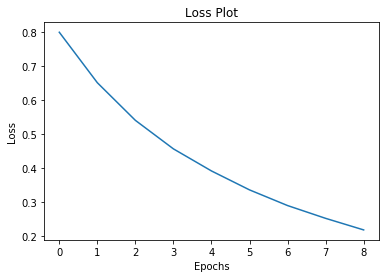

In [55]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [56]:
def evaluate(image, from_bucket=True):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image), 0) if from_bucket else tf.expand_dims(load_image_local(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [57]:
def plot_attention(image, result, attention_plot,from_bucket=True):
    temp_image = np.array(read_image_from_s3(image)) if from_bucket else np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> <unk> in a regular fit <end>
Prediction Caption: christmas is a <unk> artist are stunning <end>


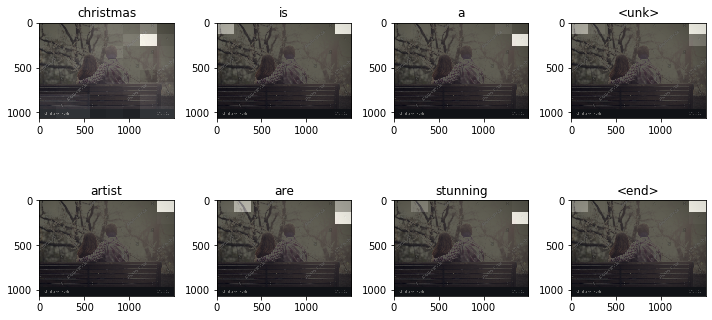

In [58]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: flag backpack <end>


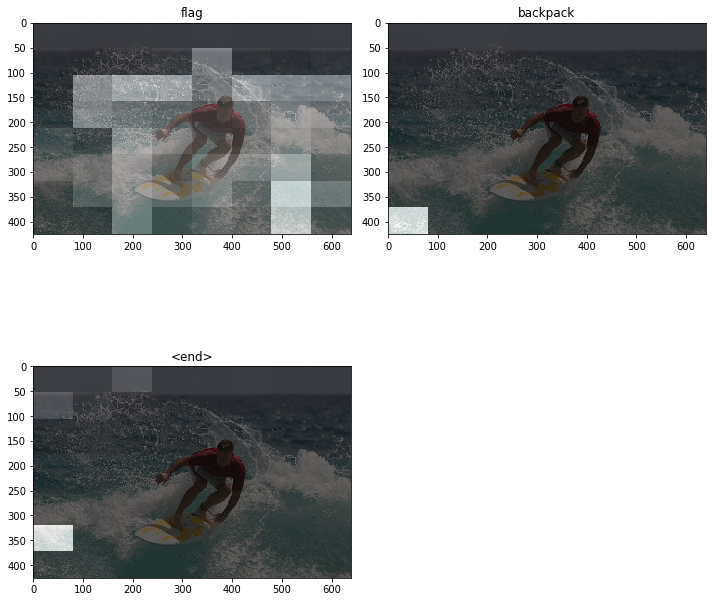

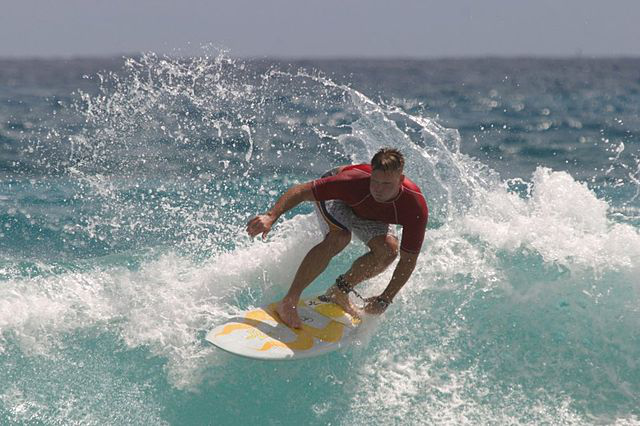

In [59]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path, False)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot, False)
# opening the image
Image.open(image_path)

In [34]:
## function to calculate BLEU score for a caption
import nltk

def BLEU_4(ref_caption, gen_caption):
    return nltk.translate.bleu_score.sentence_bleu([ref_caption], gen_caption)

def BLEU_3(ref_caption, gen_caption):
    return nltk.translate.bleu_score.sentence_bleu([ref_caption], gen_caption,  weights=(0, 0, 1, 0))

def BLEU_2(ref_caption, gen_caption):
    return nltk.translate.bleu_score.sentence_bleu([ref_caption], gen_caption,  weights=(0, 1, 0, 0))

def BLEU_1(ref_caption, gen_caption):
    return nltk.translate.bleu_score.sentence_bleu([ref_caption], gen_caption,  weights=(1, 0, 0, 0))

In [60]:
def get_captions(image_num):
    image = img_name_val[image_num]
    real_caption = [tokenizer.index_word[i]
                        for i in cap_val[image_num] if i not in [0]]
    result, attention_plot = evaluate(image)
    return real_caption, result

In [61]:
real_val_captions, gen_val_captions = [], []
for i in range(len(img_name_val)):
    if (i % 100 == 0):
        print("processing caption number, ", i)
    real_caption, gen_caption = get_captions(i)
    real_val_captions.append(real_caption)
    gen_val_captions.append(gen_caption)

processing caption number,  0
processing caption number,  100
processing caption number,  200
processing caption number,  300
processing caption number,  400
processing caption number,  500
processing caption number,  600
processing caption number,  700
processing caption number,  800
processing caption number,  900
processing caption number,  1000
processing caption number,  1100
processing caption number,  1200
processing caption number,  1300
processing caption number,  1400


InvalidArgumentError: input depth must be evenly divisible by filter depth: 4 vs 3 [Op:Conv2D]

## STOP BEFORE RUNNING
#### rename the files in np save below with something descriptive about the run!!!! 

In [62]:
np.save("real_val_captions_pre_train_20_epochs", real_val_captions)
np.save("gen_val_captions_pre_train_20_epochs", gen_val_captions)

In [36]:
total_bleu_1 = 0.0
total_bleu_2 = 0.0
total_bleu_3 = 0.0
total_bleu_4 = 0.0
for i in range(len(img_name_val)):
    real_caption, gen_caption = get_captions(i)
    total_bleu_1 += BLEU_1(real_caption, gen_caption)
    total_bleu_2 += BLEU_2(real_caption, gen_caption)
    total_bleu_3 += BLEU_3(real_caption, gen_caption)
    total_bleu_4 += BLEU_4(real_caption, gen_caption)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gra

KeyboardInterrupt: 

In [ ]:
num_val = len(img_name_val)
print("bleu 1 ", total_bleu_1/num_val)
print("bleu 2 ", total_bleu_2/num_val)
print("bleu 3 ", total_bleu_3/num_val)
print("bleu 4 ", total_bleu_4/num_val)